In [1]:
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import chart_studio.plotly as py
import pandas as pd

# need to change notebook mode when not in a notebook environment
init_notebook_mode(connected=True) 

In [2]:
df = pd.read_csv('~/state-covid-map/covid_by_state.csv')

In [3]:
# Creates a df 'covid' of states, cases, and deaths through 2021
data = df.loc[df['date'] == '2022-01-01']
data = data.drop('state', axis=1)
# Adding state abreviations makes mapping the states easier later
states = pd.read_csv('~/state-covid-map/us-state-fips.csv',header=0, 
                     names=['state','fips','abr'])
states['abr'] = states['abr'].str.strip()

covid = states.merge(data, on='fips', how='left')

In [4]:
pop = pd.read_csv('~/state-covid-map/population_by_state.csv',
                  usecols=['STATE','POPESTIMATE2019'])
pop['state']= pop['STATE']

In [5]:
# Adds population data to 'covid'
covid = covid.merge(pop, on='state', how='left')

covid = covid.drop('STATE', axis=1)

In [6]:
# Adds some calculated fields to balance state population differences
covid['mortality rate'] = ((covid['deaths']/covid['cases'])*100).round(2)
covid['Cases Per capita'] = (covid['cases']/covid['POPESTIMATE2019']).round(4)

covid= covid.rename(columns={'cases':'Total Cases','mortality rate':'Mortality Rate',
                       'deaths':'Total Deaths'})


In [7]:
# Adds a field to display when hovering on the map
covid['text'] = '_______________________________' + '<br>' + \
    covid["state"] + '<br>' + \
    'Population: ' + covid["POPESTIMATE2019"].astype(str)

In [8]:
# Lets us choose which trace is visible
cols_dd = ['Total Cases', 'Cases Per capita', 'Total Deaths', 'Mortality Rate']

visible = pd.array(cols_dd)

In [9]:
colors = {
    'Total Cases':'reds',
    'Total Deaths':'inferno_r', 
    'Mortality Rate':'sunset', 
    'Cases Per capita':'deep'
}

In [10]:
# Defines traces and buttons at same time
traces = []
buttons = []
for value in cols_dd:
    traces.append(go.Choropleth(
        locations=covid['abr'],
        locationmode = 'USA-states',
        z=covid[value].astype(float), # Field to be color-coded
        colorbar_title=value,
        colorscale=colors[value], # Color scheme to use
        text=covid['text'],
        visible= True if value==cols_dd[0] else False))

    buttons.append(dict(label=value,
                        method="update",
                        args=[{"visible":list(visible==value)},
                              {"title":f"<b>{value} of Covid-19 By State</b>"}]))

updatemenus = [{"active":0,
                "buttons":buttons,
               }]

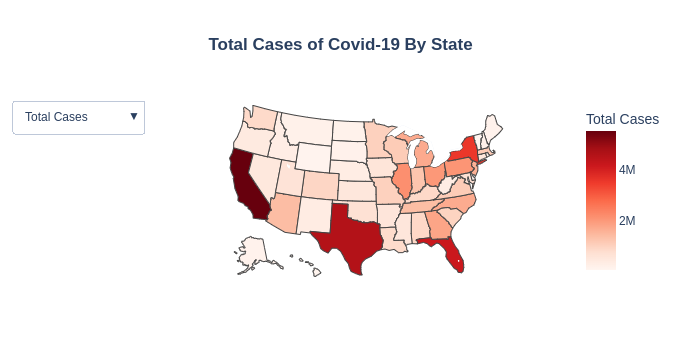

In [11]:
# Show figure
fig = go.Figure(data=traces,
                layout=dict(updatemenus=updatemenus, geo_scope= 'usa', showlegend=False))
# This is in order to get the first title displayed correctly
first_title = f"<b>{cols_dd[0]}</b> of Covid-19 By State" 
fig.update_layout(title=f"<b>{first_title}</b>",title_x=0.5)
fig.show()